# ДЗ 3. Сегментация изображений

Используя файл Web3.ipynb необходимо подготовить датасет  
https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples  
для обучения модели на сегментацию губ.  

Обучить модель на выбор из segmentation_models_pytorch https://segmentation-modelspytorch.readthedocs.io/en/latest/index.html

## Библиотеки и скрипты

In [1]:
# !pip install segmentation_models_pytorch

In [2]:
#!pip install --upgrade torch torchvision

In [3]:
# Colab
# !pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio==0.8.1 -f https://download.pytorch.org/whl/lts/1.8/torch_lts.html
# !pip install torchtext==0.9.1

In [4]:
import numpy as np
import pandas as pd
import os
import cv2

import torch
from torch import tensor
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

# import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split

from pathlib import Path
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

In [5]:
class LibsDataset(Dataset):
    def __init__(self, data, preprocessing=None):
        # Подаем наш подготовленный датафрейм
        self.data = data
        
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data.iloc[:,0]
        # и на сегментированные картинки
        self.label_arr = self.data.iloc[:,1]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data.index)
        self.class_values = [0, 1]
        self.preprocessing = preprocessing
        
    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значений
        img = cv2.cvtColor(cv2.imread(os.path.join(DATA_ROOT, self.image_arr[index])), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        img = np.asarray(img).astype('float')
        
        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
        else:
            # Нормализуем изображение в значениях [0, 1]
            img = torch.as_tensor(img) / 255.0
        img = img.permute(2, 0, 1)
        
        # считаем сегментированную картинку
        mask_image_path = os.path.join(MASK_ROOT, self.label_arr[index])
        mask = cv2.cvtColor(cv2.imread(mask_image_path), cv2.COLOR_BGR2RGB)
        cls_mask = cv2.resize(mask, (256, 256))
        cls_mask = cls_mask[..., 1]
        cls_mask = np.where(cls_mask > 128, 1, 0)[:,:]
        cls_mask = cls_mask.astype('float')
        masks = [cls_mask]
            
        masks = torch.as_tensor(masks, dtype=torch.float)
        
        return (img.float(), masks)

    def __len__(self):
        return self.data_len

In [6]:
def conv_block(in_channels,  out_channels):
    conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=out_channels),
        nn.Conv2d(out_channels, out_channels, kernel_size=3),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=out_channels)
    )
    return conv

## Загрузка и обзор данных

In [7]:
IMAGES = './data/lips_segmentation/720p'
MASKS = './data/lips_segmentation/mask'
df = pd.read_csv('./data/lips_segmentation/list.csv')
df = df.drop(columns=[    
    "width",
    "height",
    "class",
    "xmin",
    "ymin",
    "xmax",
    "ymax"
])
df.head()

,filename,mask
0,image00000200.jpg,mask00000200.png
1,image00000201.jpg,mask00000201.png
2,image00000202.jpg,mask00000202.png
3,image00000203.jpg,mask00000203.png
4,image00000204.jpg,mask00000204.png


(720, 1280, 3) (720, 1280, 3)


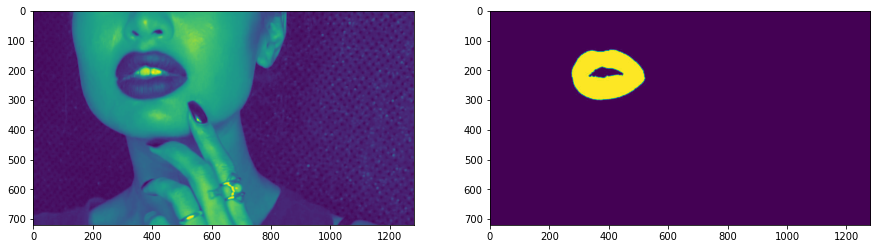

In [8]:
img = plt.imread(IMAGES + '/image00000200.jpg')
mask = plt.imread(MASKS + '/mask00000200.png')

print(img.shape, mask.shape)
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(img[..., 1])
ax[1].imshow(mask[..., 1])
plt.show()

## Предобработка данных

In [9]:
labels = ['mask1', 'mask2']

[  0 255]


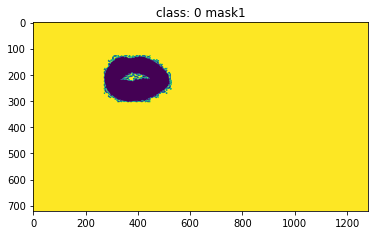

[  0 255]


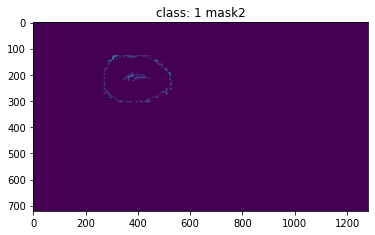

In [10]:
for i in range(2):
    mask = plt.imread(MASKS + '/mask00000200.png') * 255
    mask = np.where(mask == i, 255, 0)
    mask = mask[:,:,1]
    print(np.unique(mask))
    plt.title(f'class: {i} {labels[i]}')
    plt.imshow(mask)
    plt.show()

## Создаем модель

In [11]:
model = models.resnet34(pretrained=True)

In [12]:
# model = smp.Unet(
#     activation='sigmoid', 
#     classes=1, 
#     encoder_name='resnet34'
# )

# preprocess_input = smp.encoders.get_preprocessing_fn(
#     encoder_name='resnet34', 
#     pretrained='imagenet'
# )

In [13]:
# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(df, test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
# train_data = LibsDataset(X_train, preprocessing=preprocess_input)
# test_data = LibsDataset(X_test, preprocessing=preprocess_input)

In [14]:
train_data_loader = DataLoader(
    X_train,
    batch_size=4,
    shuffle=True
)

test_data_loader = DataLoader(
    X_test, 
    batch_size=4,
    shuffle=False
)

## Обучаем модель

### Не запускается!

Не устанавливается библиотека segmentation_models_pytorch  
Ни локально, ни на линукс, ни на колабе, убил двое суток, проблему не решил.  
К сожелению не располагаю достаточным кол-вом времени для решения задачи.

In [15]:
learning_rate = 0.006
epochs = 1

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [19]:
# sample = (next(iter(train_data_loader)))
# sample[1].shape

In [ ]:
out = model(sample[0].to(device))
out.shape

In [ ]:
plt.imshow(out[0][0].detach().cpu())

In [ ]:
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
total_steps = len(train_data_loader)
print(f"{epochs} epochs, {total_steps} total_steps per epoch")

In [ ]:
criterion = smp.utils.losses.BCELoss()
metrics = [smp.utils.metrics.IoU(), ]
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=criterion, 
    metrics=metrics,
    optimizer=optimizer,
    device=device,
    verbose=True
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=criterion, 
    metrics=metrics,
    device=device,
    verbose=True
)

In [ ]:
print(f'Epoch: 1')
train_logs = train_epoch.run(train_data_loader)

In [ ]:
test_logs = valid_epoch.run(test_data_loader)

In [ ]:
torch.save(model, './data/lips_segmentation/model.pth')
print('done')

## Проверяем модель